In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import sys, os
import pandas as pd
import matplotlib.pyplot as plt

from csidataset import *
import data_loader 
sys.path.append("/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool")
import denoise
from model import *

In [3]:
base_path = "/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/csi_dataset/localization_phone/1221_phone/5G/20Mhz/csv/all"
base_path2 = "/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/csi_dataset/localization_phone/1222_phone/5G/20MHz/csv/all"
base_path3 = "/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/csi_dataset/localization_phone/1223_phone/5G/20MHz/csv/all"
reference_points = {}
reference_points2 = {}
reference_points3 = {}
spacing = 0.6  # 每隔 0.6m

for ref_id, coord in data_loader.COORDINATES.items():
    folder_path = os.path.join(base_path, f"reference_point_{ref_id}.xlsx")
    reference_points[folder_path] = (ref_id, coord)

for ref_id, coord in data_loader.COORDINATES.items():
    folder_path = os.path.join(base_path2, f"reference_point_{ref_id}.xlsx")
    reference_points2[folder_path] = (ref_id, coord)


for ref_id, coord in data_loader.COORDINATES.items():
    folder_path = os.path.join(base_path3, f"reference_point_{ref_id}.xlsx")
    reference_points3[folder_path] = (ref_id, coord)


In [4]:
data, rp_labels, coord_labels = data_loader.load_data(reference_points)
data2, rp_labels2, coord_labels2 = data_loader.load_data(reference_points2)
data3, rp_labels3, coord_labels3 = data_loader.load_data(reference_points3)

In [5]:
amp_data = np.array(data.iloc[:, :48])  # 前 48 列是CFR
phase_data = np.array(data.iloc[:, 48:-2])  # 後 48 列是CIR

amp_data2 = np.array(data2.iloc[:, :48])  # 前 48 列是CFR
phase_data2 = np.array(data2.iloc[:, 48:-2])  # 後 48 列是CIR

amp_data3 = np.array(data3.iloc[:, :48])  # 前 48 列是CFR
phase_data3 = np.array(data3.iloc[:, 48:-2])  # 後 48 列是CIR
amp_data1_2_3 = np.concatenate((amp_data, amp_data2, amp_data3), axis=0)
phase_data1_2_3 = np.concatenate((phase_data, phase_data2, phase_data3), axis=0)
rp_labels1_2_3 = np.concatenate((rp_labels, rp_labels2, rp_labels3), axis=0)
coord_labels1_2_3 = np.concatenate((coord_labels, coord_labels2, coord_labels3), axis=0)

In [45]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy.sparse import lil_matrix, save_npz

# 你的樣本數量（73353）
num_samples = 73353  # 這裡請確保與你的數據對齊
num_labels = 49  # 49 個 RP

# 設定高斯標籤的 sigma
sigma = 0.5  # 控制模糊程度
K = 9  # 只保留最近的K個點

# 假設你有對應的坐標標籤
sample_positions = coord_labels1_2_3  # 這裡應該是 (73353, 2)，對應每個樣本的 (x, y)
rp_positions = np.array(list(data_loader.COORDINATES.values()))  # (49, 2)

# 使用稀疏矩陣存儲 soft labels
soft_labels = lil_matrix((num_samples, num_labels), dtype=np.float32)

for i, coord in enumerate(sample_positions):
    distances = cdist([coord], rp_positions, metric='euclidean').flatten()
    sorted_indices = np.argsort(distances)[:K]  # 取最近的 K 個點
    weights = np.exp(- (distances[sorted_indices] ** 2) / (2 * sigma ** 2))  # 高斯函數
    weights /= np.sum(weights)  # 正規化成概率
    soft_labels[i, sorted_indices] = weights  # 只存 K 近鄰的權重

# 存儲為 .npz 格式，避免記憶體不足
soft_labels = soft_labels.toarray()

# 顯示部分 soft labels（只轉換前 100 x 49）
soft_labels_preview = soft_labels[:100, :]
soft_labels_df = pd.DataFrame(soft_labels_preview, index=range(100), columns=range(num_labels))
print(soft_labels_df)
print(soft_labels[0])

         0         1         2         3         4    5    6    7    8    9   \
0   0.47873  0.233023  0.026873  0.000734  0.000005  0.0  0.0  0.0  0.0  0.0   
1   0.47873  0.233023  0.026873  0.000734  0.000005  0.0  0.0  0.0  0.0  0.0   
2   0.47873  0.233023  0.026873  0.000734  0.000005  0.0  0.0  0.0  0.0  0.0   
3   0.47873  0.233023  0.026873  0.000734  0.000005  0.0  0.0  0.0  0.0  0.0   
4   0.47873  0.233023  0.026873  0.000734  0.000005  0.0  0.0  0.0  0.0  0.0   
..      ...       ...       ...       ...       ...  ...  ...  ...  ...  ...   
95  0.47873  0.233023  0.026873  0.000734  0.000005  0.0  0.0  0.0  0.0  0.0   
96  0.47873  0.233023  0.026873  0.000734  0.000005  0.0  0.0  0.0  0.0  0.0   
97  0.47873  0.233023  0.026873  0.000734  0.000005  0.0  0.0  0.0  0.0  0.0   
98  0.47873  0.233023  0.026873  0.000734  0.000005  0.0  0.0  0.0  0.0  0.0   
99  0.47873  0.233023  0.026873  0.000734  0.000005  0.0  0.0  0.0  0.0  0.0   

    ...   39   40   41   42   43   44  

In [46]:
# 先切分 train 和 temp（temp 包含 validation & test）
amp_train, amp_temp, y_train, y_temp, coord_train, coord_temp = train_test_split(
    amp_data1_2_3, soft_labels, coord_labels1_2_3, test_size=0.3, random_state=42)

# 再從 temp 切分 validation 和 test
amp_val, amp_test, y_val, y_test, coord_val, coord_test = train_test_split(
    amp_temp, y_temp, coord_temp, test_size=1/3, random_state=42)

In [47]:
# **在 PyTorch 中加載 Soft Labels 和 坐標標籤**
class CSIDataset(Dataset):
    def __init__(self, amp_data, labels, coord_labels):
        self.amp_data = torch.tensor(amp_data, dtype=torch.float32)
        self.soft_labels = torch.tensor(labels, dtype=torch.float32)
        self.coord_labels = torch.tensor(coord_labels, dtype=torch.float32)  # (x, y) 標籤

    def __len__(self):
        return self.amp_data.shape[0]

    def __getitem__(self, idx):
        return self.amp_data[idx], self.soft_labels[idx], self.coord_labels[idx]
# 創建 Dataset 和 DataLoader

batch_size = 32
train_dataset = CSIDataset(amp_train, y_train, coord_train)
val_dataset = CSIDataset(amp_val, y_val, coord_val)
test_dataset = CSIDataset(amp_test, y_test, coord_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [48]:
class CNNMultiTask(nn.Module):
    def __init__(self, num_classes=49):
        super(CNNMultiTask, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        self.flatten_dim = 128 * 12  # 48 -> 24 -> 12 after pooling

        # 共享特徵層
        self.fc_shared = nn.Linear(self.flatten_dim, 128)
        self.dropout_shared = nn.Dropout(0.5)
        
        # 分支1: 分類輸出 (49 類)
        self.fc_class = nn.Linear(128, 64)
        self.dropout_class = nn.Dropout(0.5)
        self.fc_out_class = nn.Linear(64, num_classes)
        
        # 分支2: 坐標輸出 (x, y)
        self.fc_coord = nn.Linear(128, 64)
        self.dropout_coord = nn.Dropout(0.5)
        self.fc_out_coord = nn.Linear(64, 2)

    def forward(self, x):
        # Ensure input is in the shape (batch_size, channels, length)
        if x.dim() == 2:
            x = x.unsqueeze(1)
        
        if x.shape[1] != 1:
            x = x.permute(0, 2, 1)  # (batch_size, 1, 48)

        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc_shared(x))
        x = self.dropout_shared(x)
        
        # 分類輸出
        class_out = F.relu(self.fc_class(x))
        class_out = self.dropout_class(class_out)
        class_out = self.fc_out_class(class_out)  # Shape: (batch_size, 49)
        
        # 坐標輸出
        coord_out = F.relu(self.fc_coord(x))
        coord_out = self.dropout_coord(coord_out)
        coord_out = self.fc_out_coord(coord_out)  # Shape: (batch_size, 2)
        
        return class_out, coord_out

In [49]:
# 初始化模型
model = CNNMultiTask(num_classes=49).to(device)

# 顯示模型架構
summary(model, input_size=(1, 48))  # Input shape: (channels, length)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 64, 48]             256
       BatchNorm1d-2               [-1, 64, 48]             128
         MaxPool1d-3               [-1, 64, 24]               0
            Conv1d-4              [-1, 128, 24]          24,704
       BatchNorm1d-5              [-1, 128, 24]             256
         MaxPool1d-6              [-1, 128, 12]               0
            Linear-7                  [-1, 128]         196,736
           Dropout-8                  [-1, 128]               0
            Linear-9                   [-1, 64]           8,256
          Dropout-10                   [-1, 64]               0
           Linear-11                   [-1, 49]           3,185
           Linear-12                   [-1, 64]           8,256
          Dropout-13                   [-1, 64]               0
           Linear-14                   

In [50]:
# **訓練函數 (包含學習率調整、Early Stopping、最佳模型儲存)**
def train_model(model, train_loader, val_loader, num_epochs=200, lambda_coord=0.1, lr=0.001, patience=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)  # 每10個epoch學習率減半
    loss_class = torch.nn.CrossEntropyLoss()
    loss_coord = torch.nn.MSELoss()
    
    best_val_loss = float('inf')
    best_model_path = "./model_save_soft_label/best_model.pth"
    counter = 0
    
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct, total_train = 0, 0, 0
        
        for amp_batch, label_batch, coord_batch in train_loader:
            amp_batch, label_batch, coord_batch = amp_batch.to(device), label_batch.to(device), coord_batch.to(device)
            
            optimizer.zero_grad()
            pred_class, pred_coord = model(amp_batch)
            
            loss_c = loss_class(pred_class, label_batch)
            loss_xy = loss_coord(pred_coord, coord_batch)
            loss = loss_c + lambda_coord * loss_xy
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * amp_batch.size(0)
            _, predicted = torch.max(pred_class, 1)
            _, true_labels = torch.max(label_batch, 1)
            total_train += label_batch.size(0)
            train_correct += (predicted == true_labels).sum().item()
        
        avg_train_loss = train_loss / len(train_loader.dataset)
        train_acc = 100 * train_correct / total_train
        
        # **驗證階段**
        model.eval()
        val_loss, val_correct, total_val = 0, 0, 0
        
        with torch.no_grad():
            for amp_batch, label_batch, coord_batch in val_loader:
                amp_batch, label_batch, coord_batch = amp_batch.to(device), label_batch.to(device), coord_batch.to(device)
                
                pred_class, pred_coord = model(amp_batch)
                
                loss_c = loss_class(pred_class, label_batch)
                loss_xy = loss_coord(pred_coord, coord_batch)
                loss = loss_c + lambda_coord * loss_xy
                
                val_loss += loss.item() * amp_batch.size(0)
                _, predicted = torch.max(pred_class, 1)
                _, true_labels = torch.max(label_batch, 1)
                total_val += label_batch.size(0)
                val_correct += (predicted == true_labels).sum().item()
        
        avg_val_loss = val_loss / len(val_loader.dataset)
        val_acc = 100 * val_correct / total_val
        
        # **記錄 Loss 和 Accuracy**
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        
        # **儲存最佳模型**
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"✅ 儲存最佳模型 (Val Loss: {best_val_loss:.4f}) 至 {best_model_path}")
            counter = 0
        else:
            counter += 1
        
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    print("訓練完成！")
    
    # **畫出 Loss & Accuracy 曲線**
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Acc')
    plt.plot(val_accuracies, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy Curve')
    plt.legend()
    
    plt.show()
    
    return train_losses, val_losses, train_accuracies, val_accuracies

Epoch [1/200] | Train Loss: 4.0945 | Train Acc: 11.87% | Val Loss: 3.4058 | Val Acc: 40.72%
✅ 儲存最佳模型 (Val Loss: 3.4058) 至 ./model_save_soft_label/best_model.pth
Epoch [2/200] | Train Loss: 3.4991 | Train Acc: 25.62% | Val Loss: 2.8981 | Val Acc: 54.34%
✅ 儲存最佳模型 (Val Loss: 2.8981) 至 ./model_save_soft_label/best_model.pth
Epoch [3/200] | Train Loss: 3.2537 | Train Acc: 30.89% | Val Loss: 2.6567 | Val Acc: 61.89%
✅ 儲存最佳模型 (Val Loss: 2.6567) 至 ./model_save_soft_label/best_model.pth
Epoch [4/200] | Train Loss: 3.1198 | Train Acc: 33.60% | Val Loss: 2.5566 | Val Acc: 64.21%
✅ 儲存最佳模型 (Val Loss: 2.5566) 至 ./model_save_soft_label/best_model.pth
Epoch [5/200] | Train Loss: 3.0428 | Train Acc: 34.54% | Val Loss: 2.4368 | Val Acc: 65.11%
✅ 儲存最佳模型 (Val Loss: 2.4368) 至 ./model_save_soft_label/best_model.pth
Epoch [6/200] | Train Loss: 2.9821 | Train Acc: 35.93% | Val Loss: 2.3808 | Val Acc: 68.06%
✅ 儲存最佳模型 (Val Loss: 2.3808) 至 ./model_save_soft_label/best_model.pth
Epoch [7/200] | Train Loss: 2.9313

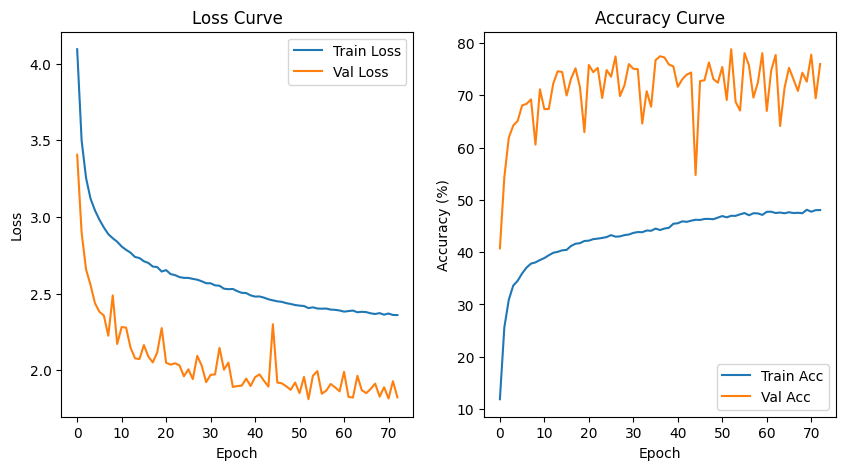

([4.094521907152846,
  3.499095987808828,
  3.2537420725482096,
  3.1198145838877958,
  3.042792145204393,
  2.9821206185291493,
  2.9313033435315305,
  2.887563038362645,
  2.8608174317952946,
  2.8379147952957893,
  2.806990539077835,
  2.7851275942199156,
  2.7667486991316217,
  2.738599496646747,
  2.7317261039766128,
  2.710504960268083,
  2.6996561533418477,
  2.67622607686256,
  2.672533442155155,
  2.64354577030061,
  2.6526911275274023,
  2.627105722669376,
  2.62015072616892,
  2.607212659778536,
  2.6022096542819235,
  2.60187285253409,
  2.595607888100291,
  2.5902435106156405,
  2.5800103391995437,
  2.5673302079086575,
  2.5668504914561923,
  2.553336873756476,
  2.5506779361584218,
  2.531484722963435,
  2.5281880390684237,
  2.5297881264597155,
  2.51543068785044,
  2.504508270229163,
  2.502957650804287,
  2.487934763318671,
  2.4801090951717812,
  2.4808353508431407,
  2.4730587690127805,
  2.462526941860347,
  2.4555229187188163,
  2.44903243518789,
  2.4457060694450

In [51]:
train_model(model, train_loader, val_loader, num_epochs=200, lambda_coord=0.1, lr=0.001, patience=20)

In [29]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
from scipy.sparse import load_npz
import matplotlib.pyplot as plt

# 你的樣本數量（73353）
num_samples = 73353  # 這裡請確保與你的數據對齊
num_labels = 49  # 49 個 RP

# **資料集切分 (Train, Validation, Test)**
test_size = 0.3
val_size = 1/3
random_state = 42

# 先切分成 train 和 temp (temp 包含 validation 和 test)
amp_train, amp_temp, y_train, y_temp, coord_train, coord_temp = train_test_split(
    amp_data1_2_3, soft_labels, coord_labels1_2_3, test_size=test_size, random_state=random_state)

# 再從 temp 切分成 validation 和 test
amp_val, amp_test, y_val, y_test, coord_val, coord_test = train_test_split(
    amp_temp, y_temp, coord_temp, test_size=val_size, random_state=random_state)

# **在 PyTorch 中加載 Soft Labels 和 坐標標籤**
class CSIDataset(Dataset):
    def __init__(self, amp_data, labels, coord_labels):
        self.amp_data = torch.tensor(amp_data, dtype=torch.float32)
        self.soft_labels = torch.tensor(labels, dtype=torch.float32)
        self.coord_labels = torch.tensor(coord_labels, dtype=torch.float32)  # (x, y) 標籤

    def __len__(self):
        return self.amp_data.shape[0]

    def __getitem__(self, idx):
        return self.amp_data[idx], self.soft_labels[idx], self.coord_labels[idx]

# **設定 DataLoader**
batch_size = 32
train_dataset = CSIDataset(amp_train, y_train, coord_train)
val_dataset = CSIDataset(amp_val, y_val, coord_val)
test_dataset = CSIDataset(amp_test, y_test, coord_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [31]:
# **測試函數**
def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    total_correct = 0
    total_samples = 0
    total_loss_class = 0
    total_loss_coord = 0
    total_mde = 0
    all_predictions = []
    all_coordinates = []
    loss_class = torch.nn.CrossEntropyLoss()
    loss_coord = torch.nn.MSELoss()
    
    with torch.no_grad():
        for amp_batch, label_batch, coord_batch in test_loader:
            amp_batch, label_batch, coord_batch = amp_batch.to(device), label_batch.to(device), coord_batch.to(device)
            
            pred_class, pred_coord = model(amp_batch)
            
            # 計算分類 Loss
            loss_c = loss_class(pred_class, label_batch)
            total_loss_class += loss_c.item() * amp_batch.size(0)
            
            # 計算坐標 Loss
            loss_xy = loss_coord(pred_coord, coord_batch)
            total_loss_coord += loss_xy.item() * amp_batch.size(0)
            
            # 計算 Mean Distance Error (MDE)
            mde = torch.mean(torch.norm(pred_coord - coord_batch, dim=1))
            total_mde += mde.item() * amp_batch.size(0)
            
            # 計算分類準確率
            _, predicted = torch.max(pred_class, 1)
            _, true_labels = torch.max(label_batch, 1)
            total_correct += (predicted == true_labels).sum().item()
            total_samples += label_batch.size(0)
            
            all_predictions.append(predicted.cpu().numpy())
            all_coordinates.append(pred_coord.cpu().numpy())
    
    avg_class_loss = total_loss_class / total_samples
    avg_coord_loss = total_loss_coord / total_samples
    avg_mde = total_mde / total_samples
    accuracy = 100 * total_correct / total_samples
    
    all_predictions = np.concatenate(all_predictions)
    all_coordinates = np.vstack(all_coordinates)
    
    print(f"Test Accuracy: {accuracy:.2f}% | Classification Loss: {avg_class_loss:.4f} | Coordinate MSE: {avg_coord_loss:.4f} | MDE: {avg_mde:.4f}")
    return accuracy, avg_class_loss, avg_coord_loss, avg_mde, all_predictions, all_coordinates

In [33]:
accuracy, avg_class_loss, avg_coord_loss, avg_mde, all_predictions, all_coordinates = evaluate_model(model, test_loader)

Test Accuracy: 96.26% | Classification Loss: 0.2178 | Coordinate MSE: 1.8724 | MDE: 1.8107


In [34]:
all_predictions

array([17, 48, 21, ..., 35, 24,  4])

In [39]:
y_true = np.argmax(y_test,axis=1)

In [40]:
y_true

array([17, 48, 21, ..., 35, 24,  4])

In [41]:
def calculate_distance(predicted_label, true_label):
    # 從 coordinates 中查找預測的座標和真實的座標
    predicted_coord = data_loader.COORDINATES.get(predicted_label, (0, 0))
    true_coord = data_loader.COORDINATES.get(true_label, (0, 0))
    
    # 計算歐幾里得距離
    distance = np.sqrt((predicted_coord[0] - true_coord[0])**2 + (predicted_coord[1] - true_coord[1])**2)
    return distance

In [42]:
# 假設你已經得到了 y_pred 和 y_test
distances = []
for pred_label, true_label in zip(all_predictions, y_true):
    dist = calculate_distance(pred_label, true_label)
    distances.append(dist)

# 計算所有預測的平均距離
average_distance = np.mean(distances)
print(f"Average distance between predicted and true locations: {average_distance:.2f} m")

Average distance between predicted and true locations: 0.14 m


In [43]:
all_errors = distances

# 计算总体误差
if all_errors:  # 确保有误差值
    mean_error = np.mean(all_errors)  # 平均误差
    median_error = np.median(all_errors)  # 中位数误差
    max_error = np.max(all_errors)  # 最大误差
    min_error = np.min(all_errors)  # 最小误差
    print(f"Mean Error: {mean_error:.2f}")
    print(f"Median Error: {median_error:.2f}")
    print(f"Max Error: {max_error:.2f}")
    print(f"Min Error: {min_error:.2f}")
else:
    print("No errors to calculate.")

Mean Error: 0.14
Median Error: 0.00
Max Error: 8.49
Min Error: 0.00
